In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sklearn as sk
import pandas
import numpy as np
import tensorflow as tf
import random
import os
import collections
import math
import time
import datetime
from tensorflow.contrib import learn
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from matplotlib import pylab, pyplot

# Allow print picture or graph in Ipython
%matplotlib inline
# Allow print all arry if command print called
np.set_printoptions(threshold=np.inf)

In [2]:
from load_data import load_file, separate_data_label, label_encoding

In [3]:
from text_cnn import TextCNN

In [4]:
# Load classified Document
document1 = load_file("2007ChallengeTrainData.xml")
id_doc1, labels, words1 = separate_data_label(document1)

In [5]:
# Encoding words by one-hot encoding
max_document_length = max([len(x.split(" ")) for x in words1])
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
x = np.array(list(vocab_processor.fit_transform(words1)))

In [6]:
# One-hot-encoding label of each document
# There are 978 documents and 45 labels
y = label_encoding(labels, False)                                      # Encode data Label in DataFrame type
y = y.as_matrix()                                                      # Convert DataFrame type to numpy array 

In [7]:
y = label_encoding(labels, False)                                      # Encode data Label in DataFrame type
y = y.as_matrix() 

In [8]:
# Randomly shuffle data
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

In [9]:
# Split train/test set
# TODO: This is very crude, should use cross-validation
# split data into training (80%) and test (20%)
x_train, x_dev = x_shuffled[:-500], x_shuffled[-500:]
y_train, y_dev = y_shuffled[:-500], y_shuffled[-500:]
print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))

Vocabulary Size: 1551
Train/Dev split: 478/500


In [10]:
embedding_dim = 128
filter_sizes = [3, 4, 5]
num_filters = 128
dropout_keep_prob = 0.5
l2_reg_lambda = 0.0
batch_size = 64
num_epochs = 200
evaluate_every = 100
checkpoint_every = 100

In [11]:
# Training
# ==================================================
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=True,
      log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=len(y[0]),
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size=embedding_dim,
            filter_sizes=filter_sizes,
            num_filters=num_filters,
            l2_reg_lambda=l2_reg_lambda)

        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.histogram_summary("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.scalar_summary("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.merge_summary(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))
        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.scalar_summary("loss", cnn.loss)
        acc_summary = tf.scalar_summary("accuracy", cnn.accuracy)

        # Train Summaries
        train_summary_op = tf.merge_summary([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.train.SummaryWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.merge_summary([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.train.SummaryWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        #if not os.path.exists(checkpoint_dir):
        #    os.makedirs(checkpoint_dir)
        #saver = tf.train.Saver(tf.all_variables())

        # Store vocabulary embedded
        #dictionary.save(os.path.join(out_dir, "vocab"))

        # Initialize all variables
        sess.run(tf.initialize_all_variables())

Writing to /home/ubuntu/workspace/tensorflow/Trying_example/runs/1474947983



In [12]:
# Sort each data and label into one pair
# then shuffle to ensure randomness 
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(len(data)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [13]:
batches = batch_iter(
        list(zip(x_train, y_train)), batch_size, num_epochs)

In [14]:
step_store = []
accuracy_store = []
eval_step = []
eval_accuracy = []
eval_precision = []
eval_recall = []
eval_f1 = []

In [15]:
def train_step(x_batch, y_batch):
    """
    A single training step
    """
    feed_dict = {
        cnn.input_x: x_batch,
        cnn.input_y: y_batch,
        cnn.dropout_keep_prob: dropout_keep_prob
    }
    _, step, summaries, loss, accuracy = sess.run(
        [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
        feed_dict)
    step_store.append(step)
    accuracy_store.append(accuracy)
    print("step {}, loss {:g}, acc {:g}".format(step, loss, accuracy))
    train_summary_writer.add_summary(summaries, step)

In [16]:
def dev_step(x_batch, y_batch, writer=None):
    """
    Evaluates model on a dev set
    """
    feed_dict = {
        cnn.input_x: x_batch,
        cnn.input_y: y_batch,
        cnn.dropout_keep_prob: 1.0
    }
    step, summaries, loss, accuracy, y_p = sess.run(
        [global_step, dev_summary_op, cnn.loss, cnn.accuracy, cnn.y_p],
        feed_dict)
    eval_step.append(step)
    eval_accuracy.append(accuracy)
    y_true = np.argmax(y_dev,1)
    precision = sk.metrics.precision_score(y_true, y_p)
    recall = sk.metrics.recall_score(y_true, y_p)
    f1_score = sk.metrics.f1_score(y_true, y_p)
    eval_precision.append(precision)
    eval_recall.append(recall)
    eval_f1.append(f1_score)
    print("step {}, loss {:g}, acc {:g}, precison {}, recall {}, f1_score {}.".format(step, loss, accuracy, precision, recall, f1_score))

In [17]:
for batch in batches:
    x_batch, y_batch = zip(*batch)
    train_step(x_batch, y_batch)
    current_step = tf.train.global_step(sess, global_step)
    if current_step % evaluate_every == 0:
        print("\nEvaluation:")
        dev_step(x_dev, y_dev, writer=dev_summary_writer)
        print("")

step 1, loss 10.1171, acc 0.015625
step 2, loss 8.61998, acc 0.046875
step 3, loss 7.58042, acc 0.046875
step 4, loss 6.5386, acc 0.0625
step 5, loss 6.47331, acc 0.03125
step 6, loss 6.1613, acc 0.078125
step 7, loss 6.8061, acc 0.046875
step 8, loss 6.11683, acc 0.166667
step 9, loss 4.91875, acc 0.203125
step 10, loss 4.20883, acc 0.21875
step 11, loss 5.25074, acc 0.234375
step 12, loss 5.8893, acc 0.21875
step 13, loss 5.01242, acc 0.21875
step 14, loss 4.83148, acc 0.3125
step 15, loss 4.84613, acc 0.1875
step 16, loss 4.71831, acc 0.266667
step 17, loss 4.64352, acc 0.203125
step 18, loss 4.42735, acc 0.203125
step 19, loss 3.64043, acc 0.375
step 20, loss 3.85598, acc 0.328125
step 21, loss 4.13251, acc 0.28125
step 22, loss 3.78454, acc 0.21875
step 23, loss 4.2096, acc 0.1875
step 24, loss 3.70847, acc 0.3
step 25, loss 3.97302, acc 0.296875
step 26, loss 2.91339, acc 0.3125
step 27, loss 3.72826, acc 0.21875
step 28, loss 3.22852, acc 0.296875
step 29, loss 3.49519, acc 0.28

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None wil

step 100, loss 1.85022, acc 0.584, precison 0.542414195953, recall 0.584, f1_score 0.523815116596.

step 101, loss 1.29597, acc 0.625
step 102, loss 1.25532, acc 0.59375
step 103, loss 0.994499, acc 0.75
step 104, loss 1.33286, acc 0.566667
step 105, loss 0.803893, acc 0.765625
step 106, loss 0.857507, acc 0.734375
step 107, loss 0.763331, acc 0.765625
step 108, loss 0.965567, acc 0.640625
step 109, loss 1.04576, acc 0.71875
step 110, loss 1.10462, acc 0.671875
step 111, loss 1.01011, acc 0.75
step 112, loss 0.716241, acc 0.766667
step 113, loss 0.894883, acc 0.78125
step 114, loss 0.761767, acc 0.796875
step 115, loss 1.2317, acc 0.734375
step 116, loss 0.783266, acc 0.765625
step 117, loss 0.792753, acc 0.796875
step 118, loss 0.941691, acc 0.75
step 119, loss 0.667216, acc 0.796875
step 120, loss 1.36098, acc 0.633333
step 121, loss 0.791436, acc 0.75
step 122, loss 0.55115, acc 0.828125
step 123, loss 0.897558, acc 0.75
step 124, loss 0.842477, acc 0.828125
step 125, loss 0.700486,

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 200, loss 1.64689, acc 0.64, precison 0.614473001041, recall 0.64, f1_score 0.597155338112.

step 201, loss 0.44183, acc 0.828125
step 202, loss 0.360767, acc 0.828125
step 203, loss 0.369759, acc 0.890625
step 204, loss 0.29786, acc 0.890625
step 205, loss 0.197997, acc 0.9375
step 206, loss 0.407113, acc 0.859375
step 207, loss 0.377894, acc 0.90625
step 208, loss 0.142967, acc 0.933333
step 209, loss 0.3443, acc 0.890625
step 210, loss 0.315574, acc 0.9375
step 211, loss 0.476498, acc 0.890625
step 212, loss 0.33063, acc 0.921875
step 213, loss 0.361021, acc 0.921875
step 214, loss 0.377514, acc 0.90625
step 215, loss 0.486205, acc 0.8125
step 216, loss 0.244355, acc 0.9
step 217, loss 0.3749, acc 0.859375
step 218, loss 0.286047, acc 0.9375
step 219, loss 0.262087, acc 0.921875
step 220, loss 0.322253, acc 0.921875
step 221, loss 0.243697, acc 0.9375
step 222, loss 0.271179, acc 0.921875
step 223, loss 0.36222, acc 0.9375
step 224, loss 0.119053, acc 0.933333
step 225, loss 0.

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 300, loss 1.57433, acc 0.684, precison 0.621454135554, recall 0.684, f1_score 0.636922556391.

step 301, loss 0.0783157, acc 0.96875
step 302, loss 0.177781, acc 0.953125
step 303, loss 0.116465, acc 0.96875
step 304, loss 0.127868, acc 0.966667
step 305, loss 0.0569281, acc 0.984375
step 306, loss 0.180233, acc 0.9375
step 307, loss 0.0954013, acc 0.984375
step 308, loss 0.176621, acc 0.9375
step 309, loss 0.303576, acc 0.890625
step 310, loss 0.0688283, acc 0.96875
step 311, loss 0.152143, acc 0.96875
step 312, loss 0.181203, acc 0.966667
step 313, loss 0.169601, acc 0.9375
step 314, loss 0.255255, acc 0.90625
step 315, loss 0.134752, acc 0.921875
step 316, loss 0.123224, acc 0.953125
step 317, loss 0.184999, acc 0.96875
step 318, loss 0.160262, acc 0.9375
step 319, loss 0.189428, acc 0.953125
step 320, loss 0.0906141, acc 0.966667
step 321, loss 0.232107, acc 0.921875
step 322, loss 0.264292, acc 0.90625
step 323, loss 0.270419, acc 0.9375
step 324, loss 0.0527301, acc 1
step 3

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 400, loss 1.57749, acc 0.684, precison 0.642827528399, recall 0.684, f1_score 0.644690597091.

step 401, loss 0.13897, acc 0.953125
step 402, loss 0.0645196, acc 0.984375
step 403, loss 0.141354, acc 0.9375
step 404, loss 0.156594, acc 0.953125
step 405, loss 0.185214, acc 0.9375
step 406, loss 0.1552, acc 0.96875
step 407, loss 0.0618699, acc 0.984375
step 408, loss 0.25299, acc 0.933333
step 409, loss 0.0873186, acc 0.96875
step 410, loss 0.111782, acc 0.953125
step 411, loss 0.143988, acc 0.96875
step 412, loss 0.213907, acc 0.953125
step 413, loss 0.0518224, acc 0.984375
step 414, loss 0.0310997, acc 0.984375
step 415, loss 0.0609013, acc 0.984375
step 416, loss 0.0116401, acc 1
step 417, loss 0.0406176, acc 1
step 418, loss 0.0367641, acc 0.984375
step 419, loss 0.0948713, acc 0.953125
step 420, loss 0.0820159, acc 0.96875
step 421, loss 0.0839385, acc 0.96875
step 422, loss 0.1564, acc 0.953125
step 423, loss 0.051993, acc 1
step 424, loss 0.203035, acc 0.9
step 425, loss 0.

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 500, loss 1.56586, acc 0.696, precison 0.634460194908, recall 0.696, f1_score 0.649174873664.

step 501, loss 0.0797164, acc 0.984375
step 502, loss 0.22073, acc 0.953125
step 503, loss 0.0785019, acc 0.96875
step 504, loss 0.0724485, acc 0.933333
step 505, loss 0.0252832, acc 1
step 506, loss 0.0907999, acc 0.96875
step 507, loss 0.105816, acc 0.96875
step 508, loss 0.190317, acc 0.921875
step 509, loss 0.0700903, acc 0.984375
step 510, loss 0.0462137, acc 0.984375
step 511, loss 0.0357479, acc 1
step 512, loss 0.113968, acc 0.966667
step 513, loss 0.0517871, acc 0.984375
step 514, loss 0.064079, acc 0.984375
step 515, loss 0.21848, acc 0.921875
step 516, loss 0.0304182, acc 1
step 517, loss 0.0316217, acc 1
step 518, loss 0.0679537, acc 0.96875
step 519, loss 0.0458808, acc 1
step 520, loss 0.122926, acc 0.933333
step 521, loss 0.102587, acc 0.953125
step 522, loss 0.0623817, acc 0.96875
step 523, loss 0.0785144, acc 0.96875
step 524, loss 0.0517517, acc 0.96875
step 525, loss 0

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 600, loss 1.59209, acc 0.696, precison 0.65591114059, recall 0.696, f1_score 0.652307837657.

step 601, loss 0.0403404, acc 1
step 602, loss 0.0441724, acc 0.984375
step 603, loss 0.0858872, acc 0.984375
step 604, loss 0.0105201, acc 1
step 605, loss 0.068439, acc 0.984375
step 606, loss 0.0340745, acc 1
step 607, loss 0.0819739, acc 0.984375
step 608, loss 0.0242801, acc 1
step 609, loss 0.0323033, acc 1
step 610, loss 0.0559283, acc 0.984375
step 611, loss 0.0357799, acc 0.984375
step 612, loss 0.0181938, acc 1
step 613, loss 0.0710819, acc 0.96875
step 614, loss 0.0357069, acc 0.984375
step 615, loss 0.157185, acc 0.96875
step 616, loss 0.015321, acc 1
step 617, loss 0.0422582, acc 0.984375
step 618, loss 0.0289117, acc 1
step 619, loss 0.0339729, acc 0.984375
step 620, loss 0.0612478, acc 0.984375
step 621, loss 0.0805319, acc 0.953125
step 622, loss 0.0204441, acc 1
step 623, loss 0.0193367, acc 1
step 624, loss 0.0396404, acc 1
step 625, loss 0.0224368, acc 1
step 626, loss 

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 700, loss 1.59418, acc 0.69, precison 0.64598154386, recall 0.69, f1_score 0.647933738831.

step 701, loss 0.0400385, acc 0.984375
step 702, loss 0.0937547, acc 0.953125
step 703, loss 0.101233, acc 0.953125
step 704, loss 0.0495054, acc 1
step 705, loss 0.0355742, acc 0.984375
step 706, loss 0.0604646, acc 0.984375
step 707, loss 0.0421169, acc 1
step 708, loss 0.0371329, acc 0.984375
step 709, loss 0.0253656, acc 0.984375
step 710, loss 0.0976896, acc 0.96875
step 711, loss 0.0667759, acc 0.984375
step 712, loss 0.115013, acc 0.966667
step 713, loss 0.0383566, acc 1
step 714, loss 0.0599896, acc 0.96875
step 715, loss 0.0360759, acc 1
step 716, loss 0.0110912, acc 1
step 717, loss 0.0175135, acc 1
step 718, loss 0.0514573, acc 0.984375
step 719, loss 0.0277343, acc 0.984375
step 720, loss 0.0860215, acc 0.966667
step 721, loss 0.0607351, acc 0.96875
step 722, loss 0.0460827, acc 0.96875
step 723, loss 0.0417341, acc 0.984375
step 724, loss 0.0230624, acc 1
step 725, loss 0.02546

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 800, loss 1.58506, acc 0.708, precison 0.64079134417, recall 0.708, f1_score 0.65739703859.

step 801, loss 0.00908214, acc 1
step 802, loss 0.0181856, acc 1
step 803, loss 0.0362663, acc 0.984375
step 804, loss 0.0172239, acc 1
step 805, loss 0.0589569, acc 0.984375
step 806, loss 0.0351679, acc 0.984375
step 807, loss 0.0374652, acc 1
step 808, loss 0.0159984, acc 1
step 809, loss 0.0537017, acc 0.96875
step 810, loss 0.0190625, acc 1
step 811, loss 0.110162, acc 0.984375
step 812, loss 0.0206578, acc 1
step 813, loss 0.0261115, acc 0.984375
step 814, loss 0.0130792, acc 1
step 815, loss 0.0257835, acc 1
step 816, loss 0.00649273, acc 1
step 817, loss 0.00655081, acc 1
step 818, loss 0.0428611, acc 0.984375
step 819, loss 0.0127696, acc 1
step 820, loss 0.0811457, acc 0.984375
step 821, loss 0.0110767, acc 1
step 822, loss 0.0471867, acc 0.984375
step 823, loss 0.00972862, acc 1
step 824, loss 0.0296798, acc 1
step 825, loss 0.066908, acc 0.953125
step 826, loss 0.0262973, acc 0

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 900, loss 1.56725, acc 0.71, precison 0.63963317502, recall 0.71, f1_score 0.662392419412.

step 901, loss 0.0069686, acc 1
step 902, loss 0.0652752, acc 0.984375
step 903, loss 0.0134155, acc 1
step 904, loss 0.0116758, acc 1
step 905, loss 0.0187441, acc 1
step 906, loss 0.00809149, acc 1
step 907, loss 0.0110126, acc 1
step 908, loss 0.0266321, acc 0.984375
step 909, loss 0.0122929, acc 1
step 910, loss 0.0366521, acc 0.984375
step 911, loss 0.0184314, acc 1
step 912, loss 0.0136989, acc 1
step 913, loss 0.00427874, acc 1
step 914, loss 0.00373572, acc 1
step 915, loss 0.0276779, acc 0.984375
step 916, loss 0.0739643, acc 0.953125
step 917, loss 0.0220086, acc 1
step 918, loss 0.0022116, acc 1
step 919, loss 0.00600067, acc 1
step 920, loss 0.00839262, acc 1
step 921, loss 0.0153423, acc 1
step 922, loss 0.0295724, acc 0.984375
step 923, loss 0.0167026, acc 1
step 924, loss 0.0408786, acc 0.984375
step 925, loss 0.0354316, acc 0.984375
step 926, loss 0.0496073, acc 0.96875
step

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1000, loss 1.54726, acc 0.71, precison 0.648814984221, recall 0.71, f1_score 0.666716479689.

step 1001, loss 0.00454232, acc 1
step 1002, loss 0.0264925, acc 0.984375
step 1003, loss 0.0155604, acc 1
step 1004, loss 0.0121762, acc 1
step 1005, loss 0.0132641, acc 1
step 1006, loss 0.0239106, acc 0.984375
step 1007, loss 0.0141373, acc 1
step 1008, loss 0.00271078, acc 1
step 1009, loss 0.020938, acc 1
step 1010, loss 0.0189288, acc 1
step 1011, loss 0.0068912, acc 1
step 1012, loss 0.0125107, acc 1
step 1013, loss 0.00392103, acc 1
step 1014, loss 0.015829, acc 1
step 1015, loss 0.00695777, acc 1
step 1016, loss 0.0243514, acc 1
step 1017, loss 0.0157183, acc 1
step 1018, loss 0.00841193, acc 1
step 1019, loss 0.0177175, acc 1
step 1020, loss 0.0653161, acc 0.984375
step 1021, loss 0.00487014, acc 1
step 1022, loss 0.0303362, acc 0.984375
step 1023, loss 0.0204759, acc 1
step 1024, loss 0.017271, acc 1
step 1025, loss 0.00787224, acc 1
step 1026, loss 0.0189057, acc 1
step 1027, 

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1100, loss 1.50447, acc 0.726, precison 0.661719345624, recall 0.726, f1_score 0.681252669843.

step 1101, loss 0.00706639, acc 1
step 1102, loss 0.017349, acc 1
step 1103, loss 0.0156127, acc 1
step 1104, loss 0.00623373, acc 1
step 1105, loss 0.00373682, acc 1
step 1106, loss 0.0599897, acc 0.984375
step 1107, loss 0.042925, acc 0.984375
step 1108, loss 0.0356002, acc 0.984375
step 1109, loss 0.00790568, acc 1
step 1110, loss 0.00398803, acc 1
step 1111, loss 0.0436148, acc 0.984375
step 1112, loss 0.00340258, acc 1
step 1113, loss 0.00382651, acc 1
step 1114, loss 0.032985, acc 0.984375
step 1115, loss 0.00435022, acc 1
step 1116, loss 0.0301241, acc 0.984375
step 1117, loss 0.00698795, acc 1
step 1118, loss 0.00689819, acc 1
step 1119, loss 0.0118401, acc 1
step 1120, loss 0.00193481, acc 1
step 1121, loss 0.0139009, acc 1
step 1122, loss 0.0124247, acc 1
step 1123, loss 0.00624063, acc 1
step 1124, loss 0.0126476, acc 1
step 1125, loss 0.0618571, acc 0.96875
step 1126, loss 0

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1200, loss 1.54178, acc 0.728, precison 0.668509252302, recall 0.728, f1_score 0.685353531743.

step 1201, loss 0.0301659, acc 0.984375
step 1202, loss 0.00445265, acc 1
step 1203, loss 0.0111791, acc 1
step 1204, loss 0.00481176, acc 1
step 1205, loss 0.0103144, acc 1
step 1206, loss 0.0731637, acc 0.984375
step 1207, loss 0.0202207, acc 1
step 1208, loss 0.00583817, acc 1
step 1209, loss 0.0115138, acc 1
step 1210, loss 0.00674963, acc 1
step 1211, loss 0.0193894, acc 1
step 1212, loss 0.0013221, acc 1
step 1213, loss 0.0176639, acc 1
step 1214, loss 0.0511498, acc 0.984375
step 1215, loss 0.00811568, acc 1
step 1216, loss 0.0207152, acc 1
step 1217, loss 0.00869714, acc 1
step 1218, loss 0.00215261, acc 1
step 1219, loss 0.00843822, acc 1
step 1220, loss 0.0290318, acc 0.984375
step 1221, loss 0.0256353, acc 0.984375
step 1222, loss 0.00548958, acc 1
step 1223, loss 0.00291304, acc 1
step 1224, loss 0.00295536, acc 1
step 1225, loss 0.0211482, acc 0.984375
step 1226, loss 0.024

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1300, loss 1.56694, acc 0.722, precison 0.660207430416, recall 0.722, f1_score 0.676672203156.

step 1301, loss 0.0176552, acc 1
step 1302, loss 0.0108831, acc 1
step 1303, loss 0.012675, acc 1
step 1304, loss 0.0236451, acc 1
step 1305, loss 0.0381795, acc 0.984375
step 1306, loss 0.0306628, acc 1
step 1307, loss 0.0080304, acc 1
step 1308, loss 0.00433763, acc 1
step 1309, loss 0.00533313, acc 1
step 1310, loss 0.0389671, acc 0.984375
step 1311, loss 0.018775, acc 1
step 1312, loss 0.0135496, acc 1
step 1313, loss 0.0264486, acc 0.984375
step 1314, loss 0.00985417, acc 1
step 1315, loss 0.0292323, acc 0.984375
step 1316, loss 0.00952079, acc 1
step 1317, loss 0.00531999, acc 1
step 1318, loss 0.0241867, acc 0.984375
step 1319, loss 0.0142909, acc 1
step 1320, loss 0.0217962, acc 1
step 1321, loss 0.0212284, acc 1
step 1322, loss 0.00931344, acc 1
step 1323, loss 0.00666631, acc 1
step 1324, loss 0.00464339, acc 1
step 1325, loss 0.0228962, acc 0.984375
step 1326, loss 0.0386075,

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1400, loss 1.508, acc 0.74, precison 0.670667012561, recall 0.74, f1_score 0.696729287037.

step 1401, loss 0.0484858, acc 0.984375
step 1402, loss 0.00609801, acc 1
step 1403, loss 0.0025235, acc 1
step 1404, loss 0.00536458, acc 1
step 1405, loss 0.00577705, acc 1
step 1406, loss 0.0198843, acc 1
step 1407, loss 0.0285465, acc 0.984375
step 1408, loss 0.00207494, acc 1
step 1409, loss 0.013682, acc 1
step 1410, loss 0.00402022, acc 1
step 1411, loss 0.00224784, acc 1
step 1412, loss 0.0322655, acc 0.984375
step 1413, loss 0.0187192, acc 1
step 1414, loss 0.0234136, acc 0.984375
step 1415, loss 0.00443401, acc 1
step 1416, loss 0.00234458, acc 1
step 1417, loss 0.0145073, acc 1
step 1418, loss 0.00500008, acc 1
step 1419, loss 0.00807125, acc 1
step 1420, loss 0.0070409, acc 1
step 1421, loss 0.0228009, acc 1
step 1422, loss 0.00386842, acc 1
step 1423, loss 0.00360387, acc 1
step 1424, loss 0.0069282, acc 1
step 1425, loss 0.0118669, acc 1
step 1426, loss 0.00270837, acc 1
step 

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

step 1500, loss 1.62517, acc 0.712, precison 0.659855085526, recall 0.712, f1_score 0.672155140573.

step 1501, loss 0.0257973, acc 0.984375
step 1502, loss 0.0110298, acc 1
step 1503, loss 0.015806, acc 1
step 1504, loss 0.00790684, acc 1
step 1505, loss 0.0360615, acc 0.96875
step 1506, loss 0.0136986, acc 1
step 1507, loss 0.0043093, acc 1
step 1508, loss 0.0246139, acc 0.984375
step 1509, loss 0.0126502, acc 1
step 1510, loss 0.00713175, acc 1
step 1511, loss 0.00895068, acc 1
step 1512, loss 0.00719921, acc 1
step 1513, loss 0.00256169, acc 1
step 1514, loss 0.00263477, acc 1
step 1515, loss 0.0496182, acc 0.984375
step 1516, loss 0.00710158, acc 1
step 1517, loss 0.00210216, acc 1
step 1518, loss 0.00344711, acc 1
step 1519, loss 0.0159377, acc 1
step 1520, loss 0.00412304, acc 1
step 1521, loss 0.00273998, acc 1
step 1522, loss 0.00662653, acc 1
step 1523, loss 0.00197795, acc 1
step 1524, loss 0.0221169, acc 0.984375
step 1525, loss 0.0517939, acc 0.984375
step 1526, loss 0.005

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

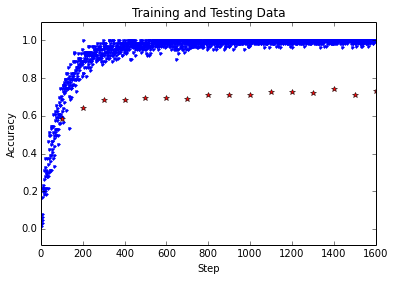

In [18]:
pyplot.plot(step_store,accuracy_store,'b.')
pyplot.plot(eval_step,eval_accuracy,'r*')
pyplot.xlim(min(step_store)-0.1,max(step_store)+0.1)
pyplot.ylim(min(accuracy_store)-0.1,max(accuracy_store)+0.1)
pyplot.xlabel("Step")
pyplot.ylabel("Accuracy")
pyplot.title("Training and Testing Data")
pyplot.show()

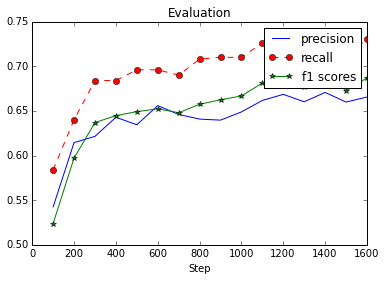

In [19]:
pyplot.plot(eval_step,eval_precision,label='precision')
pyplot.plot(eval_step,eval_recall,marker='o', linestyle='--', color='r',label='recall')
pyplot.plot(eval_step,eval_f1,marker='*', color='g',label='f1 scores')
pyplot.xlabel('Step')
pyplot.title('Evaluation')
pyplot.legend()
pyplot.show()